# オルツ 日足

In [11]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [12]:
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [13]:
pattern = re.compile(r'(.+)\.T')

symbol = '260A.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-11 00:00:00+09:00,570.0,590.0,519.0,585.0,12330500,0.0,0.0
2024-10-15 00:00:00+09:00,655.0,685.0,650.0,685.0,5385100,0.0,0.0
2024-10-16 00:00:00+09:00,718.0,765.0,695.0,750.0,20728300,0.0,0.0
2024-10-17 00:00:00+09:00,760.0,760.0,675.0,730.0,13788400,0.0,0.0
2024-10-18 00:00:00+09:00,700.0,707.0,614.0,620.0,7749900,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-19 00:00:00+09:00,542.0,550.0,537.0,539.0,671300,0.0,0.0
2025-03-21 00:00:00+09:00,542.0,544.0,534.0,535.0,496300,0.0,0.0
2025-03-24 00:00:00+09:00,538.0,541.0,536.0,540.0,322000,0.0,0.0


In [14]:
df0 = ticker.history(period='2y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-11 00:00:00+09:00,570.0,590.0,519.0,585.0,12330500,0.0,0.0
2024-10-15 00:00:00+09:00,655.0,685.0,650.0,685.0,5385100,0.0,0.0
2024-10-16 00:00:00+09:00,718.0,765.0,695.0,750.0,20728300,0.0,0.0
2024-10-17 00:00:00+09:00,760.0,760.0,675.0,730.0,13788400,0.0,0.0
2024-10-18 00:00:00+09:00,700.0,707.0,614.0,620.0,7749900,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-19 00:00:00+09:00,542.0,550.0,537.0,539.0,671300,0.0,0.0
2025-03-21 00:00:00+09:00,542.0,544.0,534.0,535.0,496300,0.0,0.0
2025-03-24 00:00:00+09:00,538.0,541.0,536.0,540.0,322000,0.0,0.0


## 日足チャートとパラボリック SAR

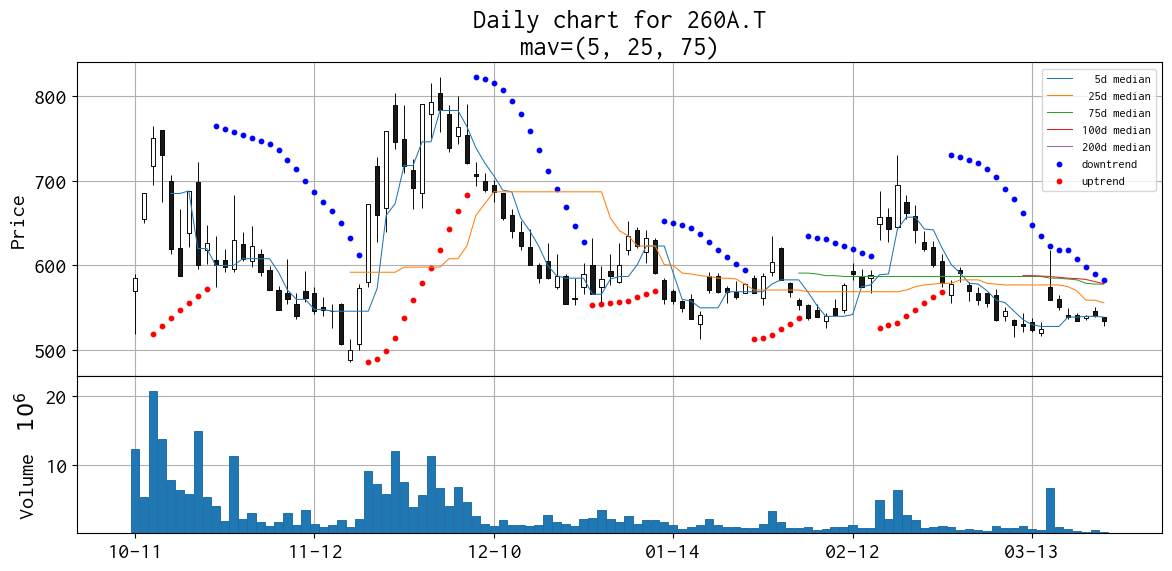

In [15]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    volume=ax[1],
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

try:
    ax[0].set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax[0].legend(loc='best', fontsize=9)


plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [16]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-26 00:00:00+09:00,539.0,539.0,529.0,534.0,327200,0.0,0.0


In [17]:
df.tail(2)['Close']

Date
2025-03-25 00:00:00+09:00    540.0
2025-03-26 00:00:00+09:00    534.0
Name: Close, dtype: float64

In [18]:
df.tail(2)['Close'].diff()

Date
2025-03-25 00:00:00+09:00    NaN
2025-03-26 00:00:00+09:00   -6.0
Name: Close, dtype: float64

In [21]:
df['Close'].rolling(5).median().tail(2)

Date
2025-03-25 00:00:00+09:00    540.0
2025-03-26 00:00:00+09:00    539.0
Name: Close, dtype: float64

In [22]:
df['Close'].rolling(25).median().tail(2)

Date
2025-03-25 00:00:00+09:00    559.0
2025-03-26 00:00:00+09:00    556.0
Name: Close, dtype: float64